<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/pixel_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload datasets to google drive and mount it on Colab

In [103]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive')
# ls 'drive/My Drive/

!unzip 'drive/My Drive/MM17-WeiboRumorSet.zip'

clear_output()
print("unzipping details have been cleared.")

unzipping details have been cleared.


In [104]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
from torchvision import datasets, transforms # for loading and transform images to tensor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt    # to plot graph

# Read all images, resize images into (image_height,image_width), convert into tensor type

Reference/Tutorial
- A Beginner’s Tutorial on Building an AI Image Classifier using PyTorch **(from data loading, processing to training and evaluation)**
   - https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [105]:
# mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'
mainfolder = 'MM17-WeiboRumorSet/'
image_height = 128
image_width  = 128
mytransform = transforms.Compose([transforms.Resize((image_height,image_width), interpolation=Image.NEAREST),   # to resize our source images
                                  transforms.ToTensor()])                                      # then convert into tensors 

dataset = datasets.ImageFolder(mainfolder, transform= mytransform) 
# NOTE: The path should point to a place with subfolders (which contain images inside).
#  It will report bugs if there is no subfolder.

labels = dataset.class_to_idx # the dataset saves the subfolder's name as the labels
# print(labels) 
# print(type(labels))

classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)

# print(type(dataset))
print('No. of images: ', len(dataset))

classes: ['nonrumor_images', 'rumor_images', 'tweets']
No. of images:  13249


In [106]:
#  function to view one image
def image_show(np_image):
  plt.figure(figsize = (5,5))
  plt.imshow(np_image) # it should be a numpy array
  plt.show()

# Pixel-domain Network

`nn.Conv2d(in_channels, out_channels, kernel_size, ...)`
  - It seems we have to specify the in_channels *manually*

`nn.MaxPool2d(kernel_size, ...`

*   kernel_size = 3 --> 3 x 3
- Max pooling: The maximum pixel value is selected. Batch size and channel size are not changed.  
'the output value of the layer with input size (N, C, H, W), output $(N, C, H_{out}, W_{out})$'
- Min pooling: The minimum pixel value of the batch is selected.
- Average pooling: The average value of all the pixels in the batch is selected.

`nn.Linear(in_features, out_features, ...`

---
**Reference/Tutorial**
- Understand how kernels work in Conv2d and pooling
  -  https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean#:~:text=Deep%20neural%20networks%2C%20more%20concretely,layer%2C%20are%20the%20convolutional%20filters.

- Convolution Neural Network (CNN)
  -  https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05#:~:text=Fully%20Connected%20Layer%20is%20simply,into%20the%20fully%20connected%20layer.
- What do the fully connected layers do in CNN?
  -  https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns/182122
- GRU with Pytorch
  - https://blog.floydhub.com/gru-with-pytorch/

In [107]:
class PixelNet(nn.Module):
    def __init__(self, image_height, image_width):
        super(PixelNet, self).__init__()
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)

        #===== For each convolution model =====%
        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d( 3, 32, 3, padding = 1), nn.ReLU(),  # (N,  3, 128, 128) --> (N, 32, 128, 128); add padding = 1 for kernel size = 3 to avoid changing output size
                                     nn.Conv2d(32, 32, 1), nn.ReLU(),               # (N, 32, 128, 128) --> (N, 32, 128, 128);
                                     nn.MaxPool2d(2))                               # (N,  3, 128, 128) --> (N, 32,  64,  64);
                                     
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), nn.ReLU(),  # (N, 32, 64, 64) --> (N, 64, 64, 64)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(),               # (N, 64, 64, 64) --> (N, 64, 64, 64)
                                     nn.MaxPool2d(2))                               # (N, 64, 64, 64) --> (N, 64, 32, 32)

        # Conv Model 3
        self.conv_M3 = nn.Sequential(nn.Conv2d(64, 64, 3, padding = 1), nn.ReLU(),  # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(),               # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.MaxPool2d(2))                               # (N, 64, 32, 32) --> (N, 64, 16, 16)

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d( 64, 128, 3, padding = 1), nn.ReLU(), # (N,  64, 16, 16) --> (N, 128, 16, 16)
                                     nn.Conv2d(128, 128, 1), nn.ReLU(),              # (N, 128, 16, 16) --> (N, 128, 16, 16)
                                     nn.MaxPool2d(2))                                # (N, 128, 16, 16) --> (N, 128,  8,  8)
        
        #===== For each branch =====%
        # Note:
        # 1. Flatten convolution layer before FC layer, the input column size = 64 neurons * pooled output size
        # 2. Since image_height and image_width are fed from outside, we need to ensure the type to int after division, otherwise gives bugs.
        # 3. Need to add a dropout layer with a prob of 0.5 after FC layer (see the reference paper)

        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.Flatten(1, -1),    # flatten from the 2nd dim (1) to the last dim (-1)
                                      nn.Linear(torch.tensor(64*image_height*image_width/2/2, dtype=torch.int), 64),
                                      nn.Dropout(0.5))

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.Linear(torch.tensor(64*image_height*image_width/4/4, dtype=torch.int), 64),
                                      nn.Dropout(0.5))

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),    
                                      nn.Linear(torch.tensor(64*image_height*image_width/8/8, dtype=torch.int), 64),
                                      nn.Dropout(0.5))

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.Linear(torch.tensor(64*image_height*image_width/16/16, dtype=torch.int), 64),
                                      nn.Dropout(0.5))
          
    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M2(out1)   # Branch 2
        out3 = self.conv_M3(out2)   # Branch 3
        out4 = self.conv_M4(out3)   # Branch 4

        v1 = self.conv_br1(out1)
        v2 = self.conv_br2(out2)
        v3 = self.conv_br3(out3)
        v4 = self.conv_br4(out4)

        return v1, v2, v3, v4


# Notes about nn.GRU 

---

- input of shape (seq_len, batch, input_size)
- h_0 of shape (num_layers * num_directions, batch, hidden_size)
  - **Question: How should this "seq_len" be in our case??? v1 has only the shape of (batch, input_size)**

- output of shape (seq_len, batch, num_directions * hidden_size)
- h_n of shape (num_layers * num_directions, batch, hidden_size)


# Below is how I interpret the architecture of the Bi-GRU network stated in the paper
- Two layers of GRU for each branch, and almost each of the GRU needs a hidden state from another GRU
- So we have to start from the GRU in the 4th branch to obtain the h4, and then feed it into GRU with v3, and similarly for the rest.
- Since we have to feed a hidden state into the GRU, we set num_layer = 1 and bidirection = False in nn.GRU


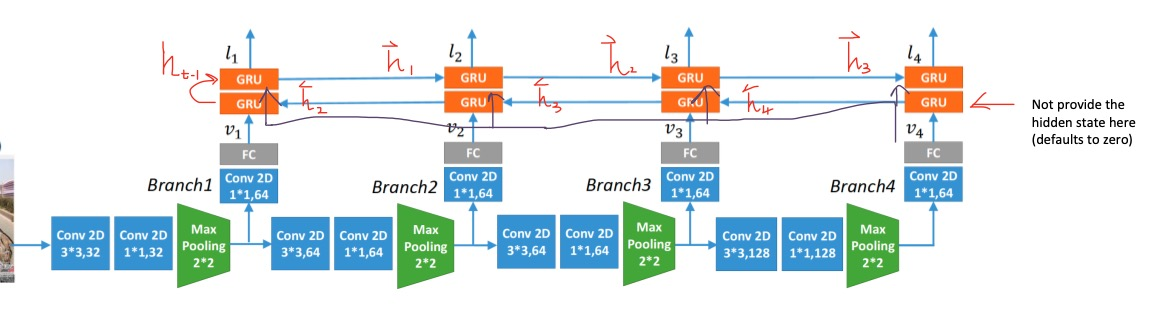

In [108]:
class GRUNet(nn.Module):
    def __init__(self):
        super(GRUNet, self).__init__()

        self.gru1 = nn.GRU(input_size=64, hidden_size=32,
                          num_layers=1, bidirectional=False)
        
        self.gru2 = nn.GRU(input_size=32, hidden_size=32,
                          num_layers=1, bidirectional=False)
        
    def forward(self, v1, v2, v3, v4):

        # backward GRU (1st layer) which reads from v4 to v1 
        out4_layer1, h4_backward = self.gru1(v4)
        out3_layer1, h3_backward = self.gru1(v3, h4_backward)
        out2_layer1, h2_backward = self.gru1(v2, h3_backward)
        out1_layer1, h1_backward = self.gru1(v1, h2_backward)

        # print(out1_layer1.shape)
        # print(h1_backward.shape)

        # forward GRU (2nd layer) which reads from v1 to v4 
        out1_layer2, h1_foreward = self.gru2(out1_layer1, h1_backward)
        out2_layer2, h2_foreward = self.gru2(out2_layer1, h1_backward)
        out3_layer2, h3_foreward = self.gru2(out3_layer1, h2_backward)
        out4_layer2, h4_foreward = self.gru2(out4_layer1, h3_backward)

        # print(out1_layer2.shape)
        # print(h1_foreward.shape)

        # concatenating the forward hidden state and the backward hidden state (see the paper)
        L1 = torch.cat((h1_foreward, h1_backward), dim=0)
        L2 = torch.cat((h2_foreward, h2_backward), dim=0)
        L3 = torch.cat((h3_foreward, h3_backward), dim=0)
        L4 = torch.cat((h4_foreward, h4_backward), dim=0)
        
        return L1, L2, L3, L4



In [109]:
net = PixelNet(image_height, image_width)
GRU = GRUNet()
# defining Loss function
loss_func = nn.CrossEntropyLoss()
# defining optimizer
optimizer = torch.optim.Adam(net.parameters()) 

# Load training set

---------
E.g., images.shape = (4, 3, 128, 128)

4 - Batch Size(no. of images loaded),

3 - channels in input,

128, 128 - shape of 1 individual image

---------


torch.Size([4, 3, 128, 128])


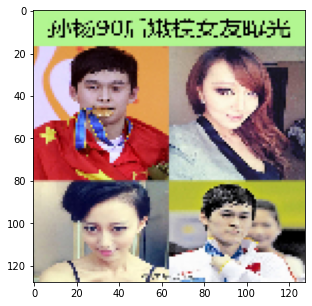

rumor_images


In [110]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 4, shuffle = True) 

data_iter = iter(trainloader)
images,labels = data_iter.__next__() 

# view original image
print(images.shape)
np_image = images[0].numpy() #converting tensor --> numpy
np_image = np.transpose(np_image, (1,2,0))
image_show(np_image)

print(classes[labels[0]])

In [111]:
epoch = 1
for i in range(epoch):
  j = 0
  for data in trainloader:  #Each time there is a batch size of 4 for each training step
                            #to update the model parameters
    if j == 1: 
      break # break the loop at j == 1 just for testing code.
    print("\n j = ", j)    
    image_data , labels = data
    print("\n images size:", image_data.shape)
    optimizer.zero_grad() 
    v1, v2, v3, v4 = net(image_data) #image_data --> input data
    print("\n v1 size:", v1.shape)
    print("\n v2 size:", v2.shape)
    print("\n v3 size:", v3.shape)
    print("\n v4 size:", v4.shape)

    v1 = v1.unsqueeze(0) # a "pytorch" way to add an extra dimension  (4, 64) --> (1, 4, 64)
    v2 = v2.unsqueeze(0)
    v3 = v3.unsqueeze(0)
    v4 = v4.unsqueeze(0)

    L1, L2, L3, L4 = GRU(v1,v2,v3,v4)
    print("\n L1 size:", L1.shape)
    print("\n L2 size:", L2.shape)
    print("\n L3 size:", L3.shape)
    print("\n L4 size:", L4.shape)
    j = j + 1

  # train_acc = model_eval(trainloader) 
  # test_acc  = model_eval(testloader)

  # print("Epoch :",i," Train Accuracy : ",train_acc)
  # print("Epoch :",i," Test Accuracy : ",test_acc," Train Accuracy : ",train_acc)


 j =  0

 images size: torch.Size([4, 3, 128, 128])

 v1 size: torch.Size([4, 64])

 v2 size: torch.Size([4, 64])

 v3 size: torch.Size([4, 64])

 v4 size: torch.Size([4, 64])

 L1 size: torch.Size([2, 4, 32])

 L2 size: torch.Size([2, 4, 32])

 L3 size: torch.Size([2, 4, 32])

 L4 size: torch.Size([2, 4, 32])


# Below are just sample code from online tutorial

In [112]:
def model_eval(dataloader):
    total = 0
    correct = 0

    j = 0
    for data in dataloader:
        print(j)
        if j == 2:
          break
        images, labels = data
        out = net(images)

        max_val, preds = torch.max(out,dim=1)
        #accuracy = (correctly predicted class / total testing class) × 100%
        total += labels.shape[0]                   # class value 
        correct += (preds == labels).sum().item()  # to summ correct in the batch then sum all of it
        accuracy = (100 * correct)/total
        j = j + 1
    return accuracy 